# 爬股；建立滾動窗口

In [ ]:
# import yfinance as yf
# import requests
# from bs4 import BeautifulSoup
# from io import StringIO
# from tqdm import tqdm  

# twse_url = "https://isin.twse.com.tw/isin/C_public.jsp?strMode=2"
# response = requests.get(twse_url)

# # 使用 BeautifulSoup 解析 HTML
# soup = BeautifulSoup(response.text, 'html.parser')
# table = soup.find('table', {'class': 'h4'})
# rows = table.find_all('tr')

# data = []
# for row in rows[1:]:  # 忽略表格標題
#     cols = row.find_all('td')
#     if len(cols) >= 5:  # 確保至少有5個欄位
#         ticker_info = cols[0].text.strip()  # 股票代號和公司名稱
#         ticker = ticker_info.split()[0]  # 股票代號
#         company_name = ticker_info.split()[1] if len(ticker_info.split()) > 1 else ""  # 公司名稱
#         state = cols[3].text.strip()
#         industry = cols[4].text.strip()  # 產業類別
#         if ticker.isnumeric():  # 確保是有效的股票代號
#             data.append([ticker, company_name, state, industry])
#     else:
#         print(f"Skipping row due to insufficient columns: {cols}")

# data = pd.DataFrame(data,columns= ['Ticker','Name','State','Sector'])        
# data['Sector'].replace(r'^\s*$', pd.NA, regex=True, inplace=True)
# data = data.dropna(subset=['Sector']) 
# data.head()
# data = data[data['State'] == '上市']

# data.head()
# data.loc[:, 'Ticker'] = data['Ticker'] + '.TW'

# stock = yf.download(" ".join(data['Ticker'].values), start="2018-10-17", end="2024-10-17")
# stock.index = stock.index.strftime('%Y-%m-%d')
# stock = stock.unstack(0)
# stock = pd.DataFrame(stock)
# stock = stock.swaplevel('Date', 'Price')
# stock = stock.reset_index()

# stock = stock.pivot(index=['Date', 'Ticker'], 
#                     columns='Price', 
#                     values=0).reset_index()

# stock = pd.merge(stock,data,on = 'Ticker')

# df = stock
# def calculate_cumulative_return(group, k = 20):
#     group['daily_return'] = group['Adj Close'].pct_change(1).shift(-1) + 1
#     group['y'] = group['daily_return'].apply(lambda x: 1 if x > 1.005 else 0)
#     # group['ret20'] = group['daily_return'].rolling(window=k).apply(lambda x: x.prod(), raw=True).shift(-19) - 1
#     # group['y'] = group['ret20'].apply(lambda x: 1 if x > 0 else 0)
#     return group

# df = df.groupby('Ticker').apply(calculate_cumulative_return).reset_index(drop = True)

# df = df.dropna()

# df['Date'] =  pd.to_datetime(df['Date'],format="%Y-%m-%d")
# df.set_index('Date', inplace=True)

# counts_df = df.groupby('Ticker').size().reset_index(name='Counts')

# different_sizes = counts_df[counts_df['Counts'] != counts_df['Counts'].iloc[0]]

# tickers_to_remove = different_sizes['Ticker'].tolist()

# df = df[~df['Ticker'].isin(tickers_to_remove)]

# df.to_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\stock.pkl')

In [3]:
df = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\Stock.pkl')
print(df['y'].value_counts(True))

y
0    0.678052
1    0.321948
Name: proportion, dtype: float64


In [ ]:
# from pandas.tseries.offsets import BDay

# def create_time_period_folders(start_date, end_date, train_years=2, predict_months=3):
#     start = pd.to_datetime(start_date)
#     end = pd.to_datetime(end_date)

#     time_windows = []
#     trading_start = start
    
#     while trading_start <= end:

#         train_end = trading_start - BDay(1)  
#         train_start = train_end - pd.DateOffset(years=train_years)  
#         trading_end =trading_start + pd.DateOffset(months = 3) -BDay(1)
        
#         time_windows.append({
#             'folder_name': f"{train_start.strftime('%Y-%m-%d')}_{train_end.strftime('%Y-%m-%d')}",
#             'trading_period': f"{trading_start.strftime('%Y-%m-%d')}_{trading_end.strftime('%Y-%m-%d')}"
#         })
        
#         trading_start += pd.DateOffset(months=3)
    
#     return time_windows

# start_date = "2020-10-17"
# end_date = "2024-10-17"

# time_windows = create_time_period_folders(start_date, end_date)
# pd.DataFrame(time_windows).to_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\time_windows.pkl')
# pd.DataFrame(time_windows).head()

,folder_name,trading_period
0,2018-10-16_2020-10-16,2020-10-17_2021-01-15
1,2019-01-15_2021-01-15,2021-01-17_2021-04-16
2,2019-04-16_2021-04-16,2021-04-17_2021-07-16
3,2019-07-16_2021-07-16,2021-07-17_2021-10-15
4,2019-10-15_2021-10-15,2021-10-17_2022-01-14


In [114]:
# from CNN_stock.image_to_tensor import StockDataset

# seed = 123
# np.random.seed(seed)

# def generate_images_by_period(df, base_output_dir, time_windows):
#     images_dict = {}
#     all_jumps = {}
    
#     for window in time_windows:
#         period_dir = os.path.join(base_output_dir, window['folder_name'])
#         os.makedirs(period_dir, exist_ok=True)
        
#         train_data = df[
#             (df.index >= window['train_start']) & 
#             (df.index < window['train_end'])
#         ]
        
#         dates = train_data.index
#         period_images = {}
    
#         i = 0
#         jumps = []
#         count = 0
        
#         while i < len(dates) - 20 and count < 30:  
#             generate_date = dates[i:i+20]

#             stock_data = df[df.index.isin(generate_date)]
            
#             lr_fea = stock_data.groupby('Ticker')[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']].transform(
#                 lambda x: (x - x.min()) / (x.max() - x.min())
#             )
            
#             feature_path = os.path.join(period_dir, f"{dates[i].strftime('%Y-%m-%d')}-{dates[i + 19].strftime('%Y-%m-%d')}.pkl")
#             lr_fea.to_pickle(feature_path)

#             dataset_create = StockDataset(
#                 state='create',
#                 stock_data=df[df.index.isin(generate_date)],
#                 output_dir=period_dir
#             )
#             image_paths, labels = dataset_create.image_paths, dataset_create.labels

#             key = f"{dates[i].strftime('%Y-%m-%d')}-{dates[i + 19].strftime('%Y-%m-%d')}"
#             value = [[(image_paths[j], labels[j]) for j in range(len(image_paths))],feature_path]
#             period_images[key] = value
            
#             count += 1  
            
#             k = np.random.randint(5, 61)
            
#             if i + 20 + k < len(dates):
#                 jump_info = {
#                     'from_date': dates[i + 20].strftime('%Y-%m-%d'),
#                     'to_date': dates[min(i + 20 + k, len(dates)-1)].strftime('%Y-%m-%d'),
#                     'jump_days': k
#                 }
#                 jumps.append(jump_info)
            
#             i += 20 + k
        
#         images_dict[window['folder_name']] = period_images
#         all_jumps[window['folder_name']] = jumps
#         print(f"Completed window {window['folder_name']} with {count} images")
    
#     return images_dict, all_jumps

# base_output_dir = r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\image'
# images_dict = generate_images_by_period(df, base_output_dir, time_windows)

# # with open(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\', 'wb') as file:
# #     pickle.dump(images_dict, file)

Completed window 2018-10-16_2020-10-16 with 30 images
Completed window 2019-01-15_2021-01-15 with 30 images
Completed window 2019-04-16_2021-04-16 with 30 images
Completed window 2019-07-16_2021-07-16 with 30 images
Completed window 2019-10-15_2021-10-15 with 30 images
Completed window 2020-01-14_2022-01-14 with 30 images
Completed window 2020-04-15_2022-04-15 with 30 images
Completed window 2020-07-15_2022-07-15 with 30 images
Completed window 2020-10-14_2022-10-14 with 30 images
Completed window 2021-01-16_2023-01-16 with 30 images
Completed window 2021-04-14_2023-04-14 with 30 images
Completed window 2021-07-14_2023-07-14 with 30 images
Completed window 2021-10-16_2023-10-16 with 30 images
Completed window 2022-01-16_2024-01-16 with 30 images
Completed window 2022-04-16_2024-04-16 with 30 images
Completed window 2022-07-16_2024-07-16 with 30 images
Completed window 2022-10-16_2024-10-16 with 30 images


# import file

In [38]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from collections import OrderedDict
import pickle

df = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\stock.pkl')

with open(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\dict.pkl', 'rb') as file:
    images_dict = pickle.load(file)
   
time_windows = pd.read_pickle(r'C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\time_windows.pkl')   

In [278]:
pd.DataFrame(time_windows)

,folder_name,trading_period
0,2018-10-16_2020-10-16,2020-10-17_2021-01-15
1,2019-01-15_2021-01-15,2021-01-17_2021-04-16
2,2019-04-16_2021-04-16,2021-04-17_2021-07-16
3,2019-07-16_2021-07-16,2021-07-17_2021-10-15
4,2019-10-15_2021-10-15,2021-10-17_2022-01-14
5,2020-01-14_2022-01-14,2022-01-17_2022-04-15
6,2020-04-15_2022-04-15,2022-04-17_2022-07-15
7,2020-07-15_2022-07-15,2022-07-17_2022-10-14
8,2020-10-14_2022-10-14,2022-10-17_2023-01-16
9,2021-01-16_2023-01-16,2023-01-17_2023-04-14


# CNN_MODEL

In [4]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from CNN_stock.CNN20 import CNN20d
from torch.utils.data import DataLoader, TensorDataset
from CNN_stock.image_to_tensor import StockDataset
import intel_extension_for_pytorch as ipex

def cnn_train(train_tensor_dataset,test_tensor_dataset):
    """
    train\test_tensor_dataset:圖片集
    adj for gcn
    """
    # inital model
    model = CNN20d()
    device = torch.device('xpu')
    model =model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)
    model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(device)
    print(f"Model is on: {next(model.parameters()).device}")
    
    # early stop; CV
    num_epochs = 100  
    patience = 10  
    best_val_loss = float('inf')

    np.random.seed(123)
    torch.manual_seed(123)

    for epoch in range(num_epochs):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss = 0.0
        
        
        train_loader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True)
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_images, batch_labels,batch_ticker in progress_bar:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)

            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            predicted_classes = outputs.argmax(dim=1)
            train_correct += (predicted_classes == batch_labels).sum().item()
            train_total += batch_labels.size(0)
            train_loss += loss.item()

            train_accuracy = train_correct / train_total * 100
            progress_bar.set_postfix({'Loss': f"{loss.item():.4f}", 'Accuracy': f"{train_accuracy:.2f}%"})
        
        train_loss /= len(train_loader)
        
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        test_loader = DataLoader(test_tensor_dataset, batch_size=32, shuffle=True)
        with torch.no_grad():
            for batch_images, batch_labels,batch_ticker in test_loader:
                batch_images = batch_images.to(device)
                batch_labels = batch_labels.to(device)
                
                outputs = model(batch_images)
                loss = criterion(outputs, batch_labels)
                
                predicted_classes = outputs.argmax(dim=1)
                val_correct += (predicted_classes == batch_labels).sum().item()
                val_total += batch_labels.size(0)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_accuracy = val_correct / val_total * 100
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
            f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
        
        # early_stop
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    return model
    

### CNN視覺化檢查

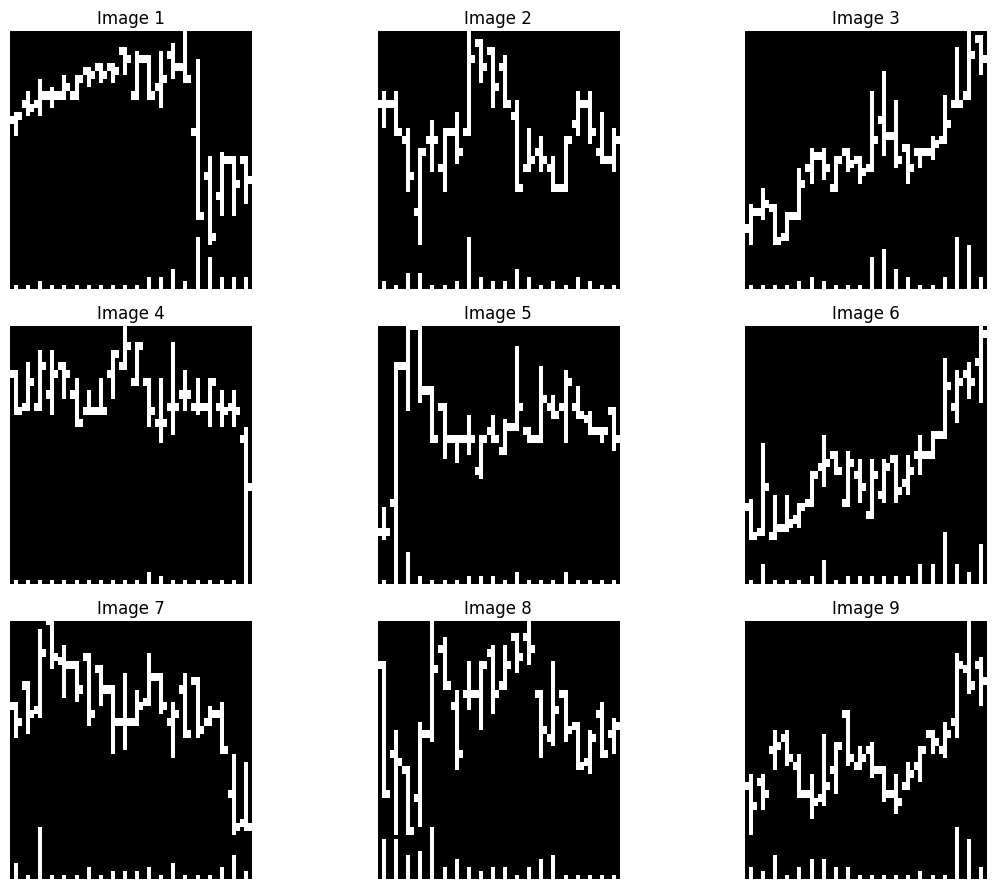

In [ ]:
# cols = 3  
# rows = 3

# fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))  #


# for i in range(9):
#     ax = axes[i // cols, i % cols]  
#     ax.imshow(batch_images[i][0].cpu().numpy(), cmap='gray') 
#     ax.axis('off')  
#     ax.set_title(f'Image {i + 1}')  

# for j in range(9, rows * cols):
#     axes[j // cols, j % cols].axis('off')

# plt.tight_layout() 
# plt.show()  


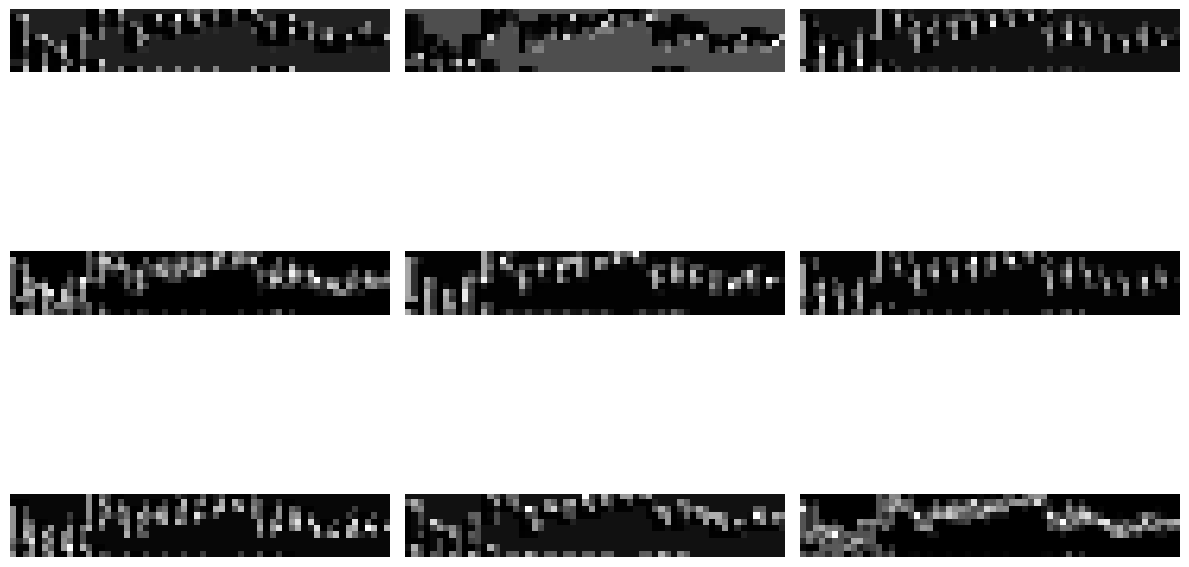

In [ ]:
# layer_outputs = model(batch_images, return_intermediates=True )
# layer1s = layer_outputs[2]

# layer_outputs = model(batch_images, return_intermediates=True )
# layer1s = layer_outputs[2]

# i = 7
# feature_maps = layer1s[i]
# feature_maps = feature_maps.cpu().detach().numpy()

# size = 3
# fig, axes = plt.subplots(size, size, figsize=(12, 3 * size))
# for i in range(9):
#     ax = axes[i // size, i % size]
#     ax.imshow(feature_maps[i], cmap='gray')
#     ax.axis('off')
# plt.tight_layout()
# plt.show()

In [ ]:
# sorted_prob_and_labels = sorted(prob_and_labels, key=lambda x: x[0], reverse=True)

# accuracies_top_k = []
# accuracies_less_k = []

# for k in range(1, 101):  
#     # Top-k Accuracy
#     correct_top = sum(1 for prob, label in sorted_prob_and_labels[:k] if label == 1)
#     accuracy_top = correct_top / k
#     accuracies_top_k.append(accuracy_top)
    
#     # Less-k Accuracy
#     correct_less = sum(1 for prob, label in sorted_prob_and_labels[-k:] if label == 1)
#     accuracy_less = correct_less / k
#     accuracies_less_k.append(accuracy_less)


# plt.figure(figsize=(12, 10))

# plt.subplot(2, 1, 1)  
# plt.plot(range(1, 101), accuracies_top_k, marker='o', linestyle='-', color='b')
# plt.xlabel('Top-k')
# plt.ylabel('Accuracy')
# plt.title('Top-k Accuracy')
# plt.grid(True)

# plt.subplot(2, 1, 2)  
# plt.plot(range(1, 101), accuracies_less_k, marker='x', linestyle='-', color='r')
# plt.xlabel('Less-k')
# plt.ylabel('Accuracy')
# plt.title('Less-k (Bottom-k) Accuracy')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# Logistic model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import scipy.sparse as sp

def lg_price_train(features, labels, l1_ratio=0.5, C=1.0):
    """
    Parameters:
    -----------
    features: torch.Tensor
    labels: list
    l1_ratio: float
    C: float 
    """
    data_df = features
    data_df['label'] = labels
    data_df = data_df.dropna()  # Drop rows with any NaNs

    X_clean = data_df.drop(columns='label').values
    y_clean = data_df['label'].values

    model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=l1_ratio,
        C=C,
        max_iter=1000,
        random_state=42
    )
    model.fit(X_clean, y_clean)
    
    return model

def lg_image_train(tensor_dataset, l1_ratio=0.5, C=1.0):
    """
    Train a logistic regression model using images from the tensor dataset.

    Parameters:
    -----------
    tensor_dataset: iterable
        An iterable of (image, label, ticker) tuples.
    l1_ratio: float
        The elastic net mixing parameter (0 < l1_ratio < 1).
    C: float
        Inverse of regularization strength; smaller values specify stronger regularization.
    
    Returns:
    --------
    model: LogisticRegression
        Trained logistic regression model.
    """
    # Collect features and labels
    flattened_features = []
    labels = []

    for image, label, ticker in tensor_dataset: 
        flattened_image = image.view(-1)  # Flatten the image tensor
        flattened_features.append(flattened_image)

        labels.append(label)

    # Create a sparse matrix for features
    X_sparse = sp.csr_matrix(np.array([f.numpy() for f in flattened_features]))

    # Standardize features
    scaler = StandardScaler(with_mean=False)  # Set with_mean=False for sparse matrix
    X_scaled = scaler.fit_transform(X_sparse)

    # Train logistic regression model
    model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=l1_ratio,
        C=C,
        max_iter=1500,
        random_state=42
    )
    model.fit(X_scaled, labels)

    return model

def flatten_price_features(df, window=20):

    df = df.reset_index(drop=True)

    df_flattened = (df
                    .groupby(df.index // window)
                    .apply(lambda x: x.values.flatten())
                    .apply(pd.Series))

    num_columns = len(df.columns)
    df_flattened.columns = [f"{window - 1 - (i // num_columns)}_{df.columns[i % num_columns]}"
                            for i in range(len(df_flattened.columns))]

    df_flattened.index = range(df_flattened.shape[0])

    return df_flattened


In [ ]:
# features = pd.read_pickle(pd.DataFrame(images_dict[0]['2018-10-16_2020-10-16']).iloc[1,3])

# temp = flatten_price_features(features, window=20)

# labels = np.array(pd.DataFrame(images_dict[0]['2018-10-16_2020-10-16']).iloc[0,3])[:,1].astype(int)

# lg_price_model = lg_price_train(temp,labels)

# GCN

### create sector network

In [204]:
# xpu目前不支持 稀疏矩陣運算
import scipy.sparse as sp
import torch.nn.functional as F
from pygcn.models import GCN

def normalize(mx):
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx

def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape, dtype=torch.float32)

def accuracy(output, labels):
    preds = output.max(1)[1].type_as(labels)
    correct = preds.eq(labels).float()  
    correct = correct.sum()
    return correct / len(labels)

class Args:
    no_xpu = False
    fastmode = False
    seed = 42
    epochs = 100
    lr = 0.01
    weight_decay = 5e-4
    hidden = 64
    dropout = 0.5
    
temp = df[['Ticker','Sector']].drop_duplicates(subset='Ticker', keep='first')
ticker_sector_map = temp.set_index('Ticker')['Sector']
sector_array = ticker_sector_map.values
adj_matrix = np.equal.outer(sector_array, sector_array).astype(int)

# adj = sp.csr_matrix(np.array(adj_matrix)[:,:],dtype = np.float32)
# adj = normalize(adj + sp.eye(adj.shape[0]))
# adj = sparse_mx_to_torch_sparse_tensor(adj)

del temp,ticker_sector_map,sector_array

In [205]:
import time
import torch.optim as optim

def gcn_image_train(tensor_dataset, adj, existing_model=None, reset_weights=False):
    """
    GCN 模型訓練函數，支持增量學習
    
    Parameters:
    -----------
    tensor_dataset : Dataset
        訓練數據集
    adj : tensor
        鄰接矩陣
    existing_model : GCN, optional
        現有的GCN模型，用於增量學習
    reset_weights : bool, optional
        是否重置模型權重，默認False
    
    Returns:
    --------
    GCN : 訓練後的模型
    """
    
    # features processing
    flattened_features = []
    labels = []
    
    for image, label, ticker in tensor_dataset: 
        flattened_image = image.view(-1)
        flattened_features.append(flattened_image.numpy())  
        labels.append(label.numpy()) 

    flattened_features = np.array(flattened_features)
    y = np.array(labels)
    y = torch.LongTensor(y).to(device)

    flattened_features = sp.csr_matrix(flattened_features, dtype=np.float32)
    flattened_features = torch.FloatTensor(flattened_features.todense()).to(device)
    
    # initial model
    args = Args()
    args.xpu = not args.no_xpu and torch.xpu.is_available()

    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.xpu:
        torch.xpu.manual_seed(args.seed)

    # 檢查是否使用現有模型
    if existing_model is not None and not reset_weights:
        gcn_model = existing_model
        print("Using existing model for incremental learning")
    else:
        gcn_model = GCN(nfeat=flattened_features.shape[1],
                        nhid=args.hidden,
                        nclass=2,
                        dropout=args.dropout).to(device)
        print("Initializing new model")

    # 確保模型在正確的設備上
    gcn_model = gcn_model.to(device)
    optimizer = optim.Adam(gcn_model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # Training function
    def train(epoch):
        t = time.time()
        gcn_model.train()
        optimizer.zero_grad()
        
        output = gcn_model(flattened_features, adj.to(device))
        loss_train = F.cross_entropy(output, y)
        acc_train = accuracy(output, y)
        
        loss_train.backward()
        optimizer.step()

        if epoch % 10 == 0:  # 每10個epoch打印一次，避免輸出過多
            print(f'Epoch: {epoch + 1:04d}, loss_train: {loss_train.item():.4f}, acc_train: {acc_train:.4f}, time: {time.time() - t:.4f}s')
        
        return loss_train.item(), acc_train

    # Training loop
    t_total = time.time()
    losses = []
    accuracies = []
    
    for epoch in range(args.epochs):
        loss, acc = train(epoch)
        losses.append(loss)
        accuracies.append(acc)
        
        # # 可以加入早停機制
        # if len(losses) > 5 and np.mean(losses[-5:]) > np.mean(losses[-10:-5]):
        #     print("Early stopping due to increasing loss")
        #     break
            
    print("Optimization Finished!")
    print(f"Total time elapsed: {time.time() - t_total:.4f}s")
    print(f"Final training accuracy: {accuracies[-1]:.4f}")
    
    return gcn_model

In [ ]:
image_df = np.array(pd.DataFrame(images_dict[0]).iloc[0, 0][0])
image_paths = list(image_df[:,0])
labels = list(image_df[:,1].astype(int))
tensor_dataset = StockDataset(state='transform', image_paths=image_paths, labels=labels)
adj = torch.tensor(adj_matrix, dtype=torch.float32)
gcn_model = gcn_image_train(tensor_dataset,adj)

# 訓練model

In [268]:
def random_cnn_sample(period_images):
    label_data = {0: [], 1: []}

    for data_list in [period_images[key][0] for key in period_images]:
        label_data[0].extend([item for item in data_list if item[1] == 0])
        label_data[1].extend([item for item in data_list if item[1] == 1])

    max_samples = min(len(label_data[0]), len(label_data[1]), 2500)
    sampled_data = random.sample(label_data[0], max_samples) + random.sample(label_data[1], max_samples)
    random.shuffle(sampled_data)  

    sampled_data = np.array(sampled_data)
    image_paths, labels = sampled_data[:, 0], sampled_data[:, 1].astype(int)

    #if imlabnce: undersampling
    if labels.mean() > 0.8 or labels.mean() < 0.2:
        rus = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
        df_resampled, labels = rus.fit_resample(pd.DataFrame({'path': image_paths, 'label': labels}), labels)
        image_paths = df_resampled['path'].tolist()

    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=0.3, random_state=42
    )

    train_tensor_dataset = StockDataset(state='transform', image_paths=train_paths, labels=train_labels)
    test_tensor_dataset = StockDataset(state='transform', image_paths=test_paths, labels=test_labels)
    
    return train_tensor_dataset, test_tensor_dataset

def random_gcn_sample(period_images):
    
    train_tensors = []
    selected_keys = random.sample(list(period_images.keys()), 25)

    for key in selected_keys:
        image_df = pd.DataFrame(period_images[key][0])
        image_paths = list(image_df[0])
        labels = list(image_df[1])
        train_tensor = StockDataset(state='transform', image_paths=image_paths, labels=labels)
    
    train_tensors.append(train_tensor)
    
    return train_tensors

def random_lg_price_sample(folder, df):

    train = df[df['folder_name'] == folder].copy()
    
    unique_tickers = df['Ticker'].unique()
    

    valid_indices = train.index[:-20]
    

    features = []
    labels = []
    target_size = 5000
    

    cols_to_process = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    

    def normalize_features(group):
        min_vals = group[cols_to_process].min()
        max_vals = group[cols_to_process].max()
        return (group[cols_to_process] - min_vals) / (max_vals - min_vals)
    

    grouped_data = {ticker: train[train['Ticker'] == ticker] for ticker in unique_tickers}
    
    while len(features) < target_size:

        batch_size = min(100, target_size - len(features))

        random_indices = np.random.randint(0, len(valid_indices), batch_size)
        random_tickers = np.random.choice(unique_tickers, batch_size)
        
        for idx, ticker in zip(random_indices, random_tickers):
            ticker_data = grouped_data[ticker]
            sample_indices = valid_indices[idx:idx+20]
            
            sample = ticker_data[ticker_data.index.isin(sample_indices)]
            
            if len(sample) == 20:

                feature = normalize_features(sample)
                label = sample['y'].iloc[-1]
                
                features.append(feature)
                labels.append(label)
                
                if len(features) >= target_size:
                    break
    features_array = np.array(features) 
    features_reshaped = features_array.reshape(-1, features_array.shape[-1])  

    features = pd.DataFrame(features_reshaped, columns=['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'])
    
    return features, labels

In [231]:
df['folder_name'] = None

for _, window in pd.DataFrame(time_windows).iterrows():

    trading_start, trading_end = window['folder_name'].split('_')
    trading_start = pd.to_datetime(trading_start)
    trading_end = pd.to_datetime(trading_end)

    mask = (df.index >= trading_start) & (df.index <= trading_end)
    
    df.loc[mask, 'folder_name'] = window['folder_name']

In [282]:
temp

,19_Adj Close,19_Close,19_High,19_Low,19_Open,19_Volume,18_Adj Close,18_Close,18_High,18_Low,...,1_Low,1_Open,1_Volume,0_Adj Close,0_Close,0_High,0_Low,0_Open,0_Volume,label
0,0.222223,0.222223,0.000000,0.400002,0.375001,0.305273,0.111109,0.111109,0.100002,0.400002,...,0.900002,0.624999,0.350265,0.666664,0.666664,0.500000,1.000000,0.624999,0.213409,1
1,0.000000,0.206897,0.192000,0.168317,0.097345,0.129984,0.049180,0.000000,0.000000,0.029703,...,0.712871,1.000000,0.422949,0.893442,0.887931,0.864000,0.940594,0.849557,0.251775,0
2,0.721805,0.721805,0.559322,0.620370,0.464286,0.560896,0.834587,0.834587,0.516949,0.759259,...,0.000000,0.437500,0.058869,0.278196,0.278196,0.000000,0.120370,0.000000,0.037742,0
3,0.428571,0.428570,0.333333,0.466667,0.375000,0.293696,0.571429,0.571428,0.444445,0.533334,...,0.333333,0.312500,0.124701,0.571429,0.571428,0.444445,0.600000,0.499999,0.000000,1
4,0.875000,0.875000,0.950000,0.954545,0.950000,0.678919,1.000000,1.000000,1.000000,0.954545,...,0.000000,0.099999,0.453040,0.166667,0.166667,0.050000,0.136364,0.000000,0.228104,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.179273,0.500000,0.409091,0.500001,0.476190,0.003753,0.195569,0.520833,0.431818,0.578948,...,0.815789,0.785715,0.871380,0.880067,0.854167,0.886364,1.000000,1.000000,0.456181,0
4996,0.433334,0.433333,0.607142,0.500000,0.607142,0.209207,0.400000,0.399999,0.428570,0.470589,...,0.205882,0.214286,0.455401,0.199999,0.199999,0.035714,0.205882,0.071429,0.428732,1
4997,0.180328,0.180328,0.112500,0.081967,0.024390,0.128686,0.213115,0.213115,0.112500,0.131148,...,0.409836,0.621951,0.622479,0.639344,0.639344,0.525000,0.672131,0.536585,0.316221,0
4998,0.992366,0.992367,1.000000,1.000000,0.977612,0.636193,0.908398,0.908397,1.000000,0.954887,...,0.060151,0.089553,0.095999,0.030535,0.030534,0.000000,0.000000,0.000000,0.026192,0


In [280]:
features,labels = random_lg_price_sample(folder,df)

In [ ]:
import joblib
device = torch.device('xpu')
base_output_dir = r"C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models"

# model_paths = {}
os.makedirs(base_output_dir, exist_ok=True)

for folder in pd.DataFrame(time_windows)['folder_name']:

    folder_path = os.path.join(base_output_dir, folder)
    os.makedirs(folder_path, exist_ok=True)

    # model_paths[folder] = {
    #     'cnn_model': os.path.join(folder_path, 'cnn_model.pth'),
    #     'lg_model': os.path.join(folder_path, 'lg_image_model.pkl'),
    #    'gcn_model' = os.path.join(folder_path, 'gcn_model.pth')
    # }
    model_paths[folder]['lg_price_model'] = os.path.join(folder_path, 'lg_price_model.pkl')


    # train_period = images_dict[folder]
    # train_tensor_dataset, test_tensor_dataset = random_cnn_sample(train_period)
    
    # cnn_model = cnn_train(train_tensor_dataset, test_tensor_dataset)
    # torch.save(cnn_model.state_dict(), model_paths[folder]['cnn_model'])
    # print(f"CNN model saved to {model_paths[folder]['cnn_model']}")   


    # adj = torch.tensor(adj_matrix, dtype=torch.float32)
    # train_tensors = random_gcn_sample(train_period)
    # gcn_model = None  # 初始化為 None

    # for i, train_tensor in enumerate(train_tensors):
    #     print(f"\nTraining batch {i+1}/{len(train_tensors)}")

    #     gcn_model = gcn_image_train(
    #         tensor_dataset=train_tensor,
    #         adj=adj,
    #         existing_model=gcn_model,  
    #         reset_weights=False  
    #     )
    
    # torch.save(gcn_model, model_paths[folder]['gcn_model'])
    
    # lg_image_model = lg_image_train(train_tensor_dataset, l1_ratio=0.5, C=1.3)
    # joblib.dump(lg_image_model, model_paths[folder]['lg_model'])
    # print(f"LG Image model saved to {model_paths[folder]['lg_model']}")

    temp = flatten_price_features(features, window=20)
    features,labels = random_lg_price_sample(folder,df)
    lg_price_model = lg_price_train(temp,labels)
    joblib.dump(lg_price_model, model_paths[folder]['lg_price_model'])
    print(f"LG Image model saved to {model_paths[folder]['lg_price_model']}")


LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2018-10-16_2020-10-16\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2019-01-15_2021-01-15\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2019-04-16_2021-04-16\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2019-07-16_2021-07-16\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2019-10-15_2021-10-15\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2020-01-14_2022-01-14\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2020-04-15_2022-04-15\lg_price_model.pkl
LG Image model saved to C:\Users\USER\Desktop\113-1\GCNs\CNN_Stock\training\models\2020-07-15_2022-07-15\lg_price_model.pkl
LG Image